In [1]:
import numpy as np
import scipy.linalg
import scipy.signal
import scipy.optimize
import networkx as nx
import matplotlib.pyplot as plt
import math
from tqdm import tqdm

from general_graph_utils import *

In [2]:
plt.rc("text", usetex=False)
plt.rc("font", family = "serif",size=14)
plt.rc("figure",figsize=(10,8))
%config InlineBackend.figure_format = 'retina'

In [3]:
# Create a unicyclic graph in NetworkX

def unicycle_graph(n):
    """
    Generates a reversible unicyclic linear framework graph of size n.
    
    Parameters
    ----------
    n : integer
        the size (or number of vertices) of the graph
    
    Returns
    -------
    G : NetworkX DiGraph object
        directed graph
    
    G_ud : NetworkX Graph object
        undirected graph
    """
    
    G = nx.DiGraph()
    G_ud = nx.Graph()
    
    # determine the number of nodes in G
    G_size = n
    
    # add nodes to G and G_ud
    nodes = np.arange(1,G_size+1,step=1)
    G.add_nodes_from(nodes)
    G_ud.add_nodes_from(nodes)
    
    for i in range(2,G_size+1):
        u = i-1
        v = i
        G.add_edge(u,v)
        G.add_edge(v,u)
        G_ud.add_edge(u,v)
        
    G.add_edge(G_size,1)
    G.add_edge(1,G_size)
    G_ud.add_edge(1,G_size)
    
    return G, G_ud

In [4]:
# Compute the correlation function from a transition rate matrix

def correlation_function_general(t, W, n):
    exp_Wt = scipy.linalg.expm(W * t) # Compute the matrix exponential e^(Wt)
    #p = np.zeros((1,n))
    #p[0] = 1
    #return (exp_Wt[0]*p)[0] # e^(Wt)[11] Prob of being in 1 at time t given was in 1 at time 0
    return exp_Wt[0][0]

In [5]:
# Create a 40-state unicicyclic network, as this number of states

N = 40
G, G_ud = unicycle_graph(N)

In [6]:
# Create data structures that contain structural information about the graph (nodes, edges). Define a cycle basis using the NetworkX function cycle_list
node_list = get_nodes(G)
num_nodes = len(node_list)
edge_list = get_edges(G)

cycle_list = get_cycles(G_ud)
num_cycles = len(cycle_list)

print(cycle_list)

[[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 1]]


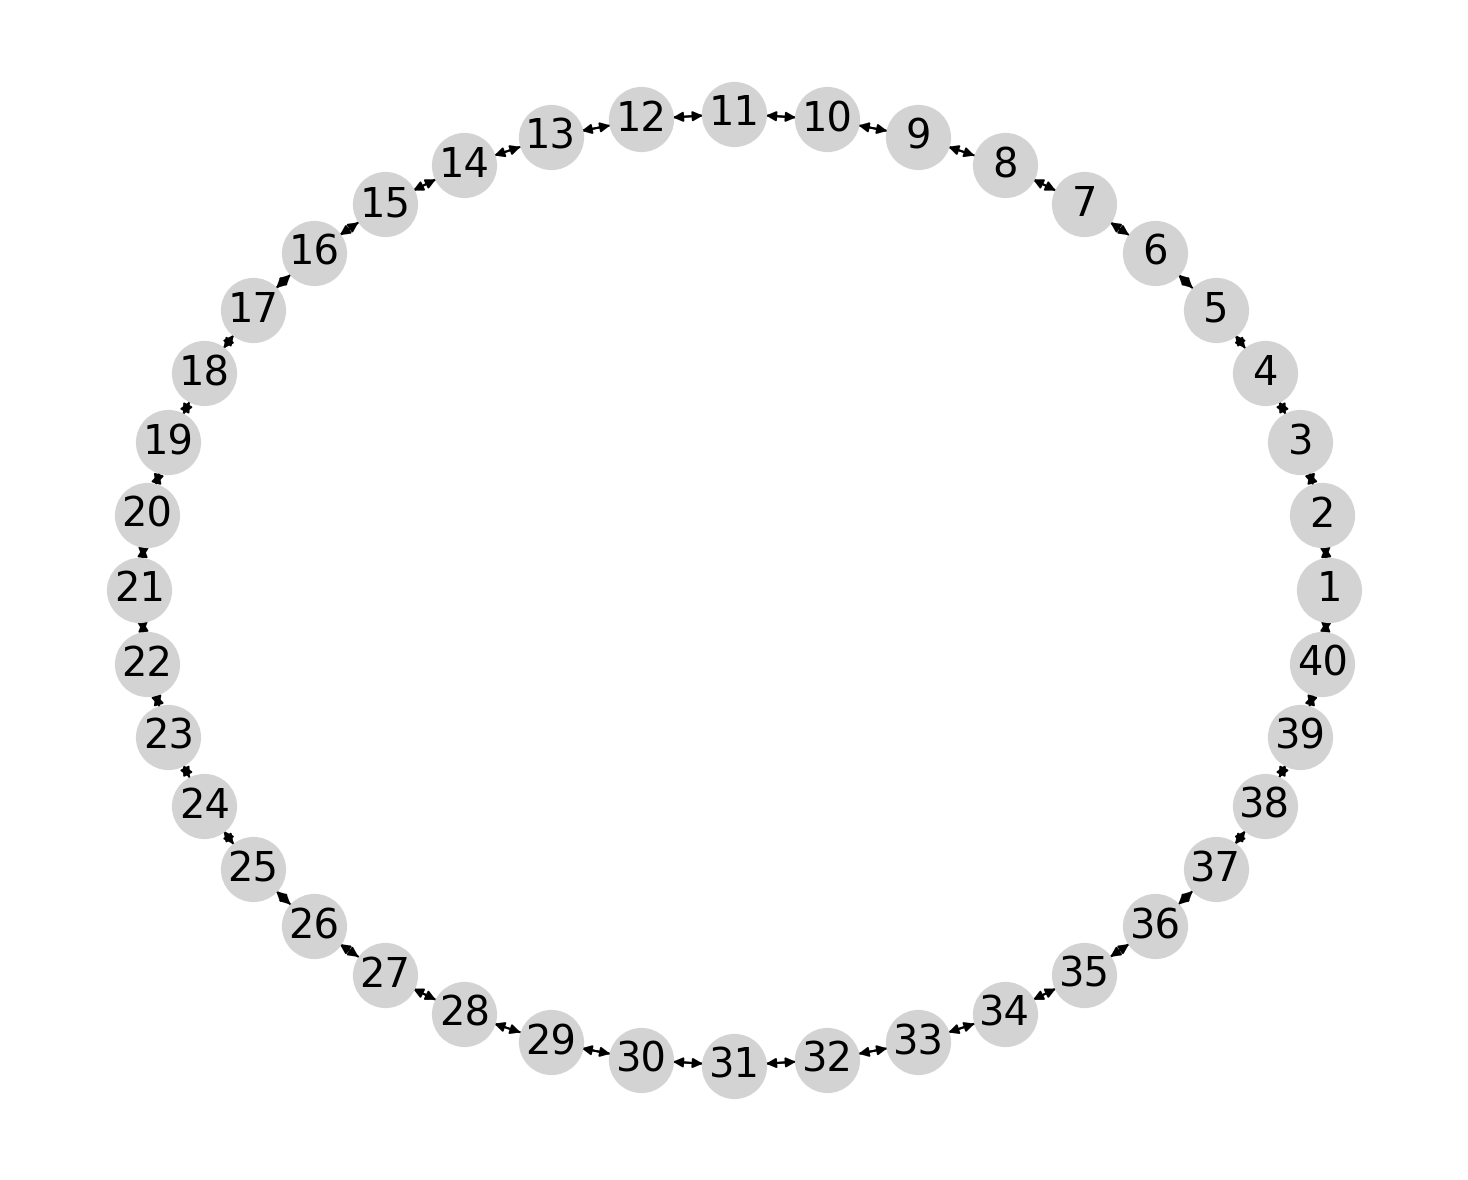

In [7]:
# Draw a picture of the graph

node_labels = {}

for node in node_list:
    node_labels[node] = str(node)

nx.draw(G, pos=nx.circular_layout(G), labels=node_labels, with_labels=True,node_size=1000, node_color = 'lightgray', font_size=20, font_color='black', font_family='sans-serif')
plt.savefig('40_states.png')

In [8]:
# Determine the forward and reverse rates based off a fixed thermodynamic force (consistent with Barato Seifert)

k_m = 1.0
A = 200
k_p = np.round(k_m*np.exp(A/N),4)
print(k_p)

148.4132


In [9]:
# Assign parameter values to the graph itself and create data structures that contain the edge label information in the same sequence they are listed in in the cycle basis output
# these data structures are used to compute the affinity later

edge_labels_forward = np.array([])
edge_labels_backward = np.array([])

for i in range(num_nodes-1):
    u = cycle_list[0][i]
    v = cycle_list[0][i+1]
    
    G[u][v]['weight'] = k_p
    edge_labels_forward = np.append(edge_labels_forward, k_p)
    
    G[v][u]['weight'] = k_m
    edge_labels_backward = np.append(edge_labels_backward, k_m)

G[cycle_list[0][-1]][cycle_list[0][0]]['weight'] = k_p
edge_labels_forward = np.append(edge_labels_forward, k_p)
G[cycle_list[0][0]][cycle_list[0][-1]]['weight'] = k_m
edge_labels_backward = np.append(edge_labels_backward, k_m)

In [10]:
# create a dictionary and a list of all the edge: label pairs

label_dict = {e: G[e[0]][e[1]]['weight'] for e in G.edges}
label_list = np.fromiter(label_dict.values(), dtype=float)

In [11]:
# from those, compute the transition matrix (Laplacian matrix)

W = Laplacian_all(edge_list,label_list,node_list)

In [12]:
# Compute the affinity (fixed originally)
affinity = np.round(np.log(np.prod(edge_labels_forward)/np.prod(edge_labels_backward)),4)
affinity

200.0

In [13]:
W = Laplacian_all(edge_list,label_list,node_list)
eigvals, eigvecs = scipy.linalg.eig(W)

x_i = np.round(np.abs(np.sort(eigvals)[-2].imag),4)
x_r = np.round(np.abs(np.sort(eigvals)[-2].real),4)

print(x_i, x_r)

# number of coherent oscillations
R = np.round(x_i/x_r,4)
print(R)

23.0605 1.8395
12.5363


In [14]:
# Compute the oscillation coherence from the eigenvalues and eigenvectors

def oscillation_coherence(W):
    eigvals, eigvecs = scipy.linalg.eig(W)
    x_i = np.round(np.abs(np.sort(eigvals)[-2].imag),4)
    x_r = np.round(np.abs(np.sort(eigvals)[-2].real),4)
    
    R = np.round(x_i/x_r,4)
    
    #decay time
    #tau = 1/x_r
    # oscillation period
    #omega = (2*math.pi)/x_i
    
    return R, x_i, x_r

In [15]:
np.round((1/np.tan(math.pi/N))* np.tanh(A / 2*N),4)

12.7062

In [16]:
# compute the upper bound derived by Barato and Seifert
def oscillation_bound(A, N):
    return np.round((1/np.tan(math.pi/N))* np.tanh(A / 2*N),4)

In [17]:
# compute the oscillation coherence and the bound
coherence, x_i, x_r = oscillation_coherence(W)
print(coherence)
bound = oscillation_bound(A, N)
print(bound)

12.5363
12.7062


In [18]:
# Time points for the plot
times = np.linspace(0.1, 5, 500)  # time from 0 to 1.5 with 500 pts
# Compute C(t) for each time point
correlation_values = [correlation_function_general(t, W, n=40) for t in tqdm(times)]

100%|█████████████████████████████████████████| 500/500 [01:09<00:00,  7.18it/s]


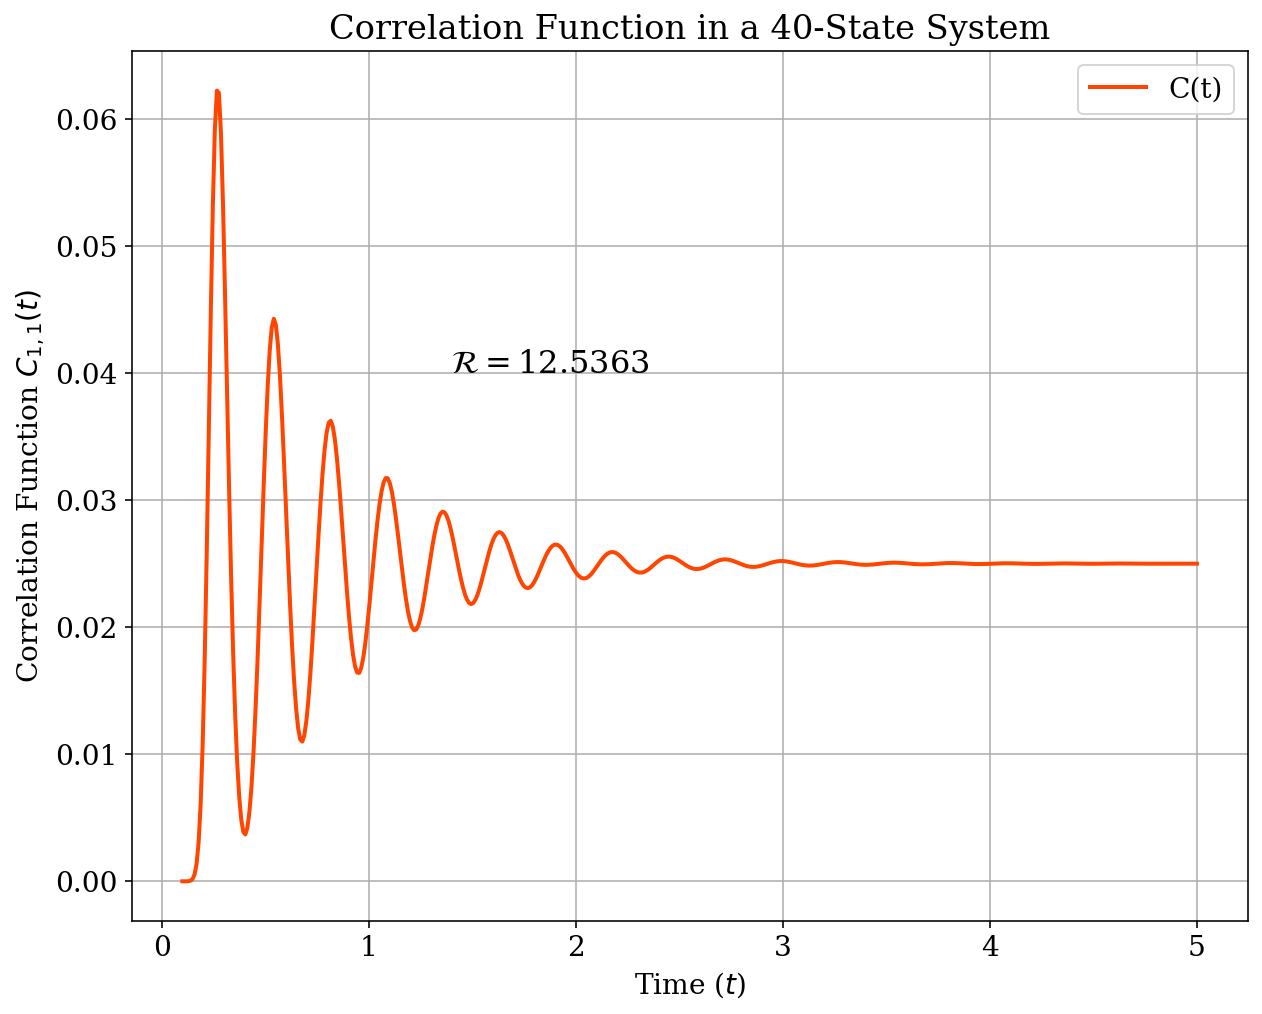

In [19]:
num_states = str(N)
coherence = str(coherence)

font = {'family': 'serif',
        'color':  'black',
        'weight': 'normal',
        'size': 16,
        }

fig, ax = plt.subplots(figsize = (10, 8))
plt.text(1.4,0.04, r'$\mathcal{R} =$' + coherence, fontdict=font)
plt.plot(times, correlation_values, color = "orangered", linewidth=2, label='C(t)')
plt.xlabel(r'Time ($t$)')
plt.ylabel(r'Correlation Function $C_{1,1}(t)$')
plt.title('Correlation Function in a '+ num_states +'-State System')
plt.legend()
plt.grid()
plt.show()

In [20]:
def gillespie_unicyclic(N, F_init, T_max):
    """
    Simulates a unicyclic chemical reaction network using the Gillespie algorithm.
    
    Parameters:
    N      : int   - Number of states in the cycle
    F_init : float - Initial thermodynamic force
    T_max  : float - Maximum simulation time
    
    Returns:
    times  : list of floats - Time points of state transitions
    states : list of ints   - States visited over time
    """
    # Initialize system state
    state = 0  # Start at state 0
    time = 0.0  # Initialize time
    F = F_init  # Initial thermodynamic force
    
    # Store trajectory
    times = [time]
    states = [state]
    
    while time < T_max:
        # Compute reverse rates dynamically
        k_minus = np.exp(-F / N)
        
        # Compute propensities
        a_plus = 1      # Forward rate
        a_minus = k_minus  # Reverse rate
        
        # Total rate
        a_total = a_plus + a_minus
        
        # Generate time step from exponential distribution
        tau = -np.log(np.random.rand()) / a_total
        time += tau
        
        if time > T_max:
            break
        
        # Determine which reaction occurs
        if np.random.rand() < a_plus / a_total:
            state = (state + 1) % N  # Forward move
        else:
            state = (state - 1) % N  # Reverse move
        
        # Update thermodynamic force dynamically in logarithmic steps
        F *= 1.01  # Modify as needed
        
        # Store results
        times.append(time)
        states.append(state)
    
    return times, states

In [21]:
def plot_trajectory(times, states):
    """
    Plots the state trajectory over time.
    """
    fig, ax = plt.subplots(figsize = (10, 8))
    plt.step(times, states, where='post', label='State Trajectory', linewidth = 2, color='deeppink')
    plt.xlabel('Time')
    plt.ylabel('State')
    plt.title('Gillespie Simulation of 40-State Unicyclic Network')
    plt.legend()
    plt.grid()
    plt.show()

In [22]:
# Example usage
N = 40         # Number of states in cycle
F_init = 200  # Initial thermodynamic force
T_max = 100   # Maximum simulation time
times, states = gillespie_unicyclic(N, F_init, T_max)

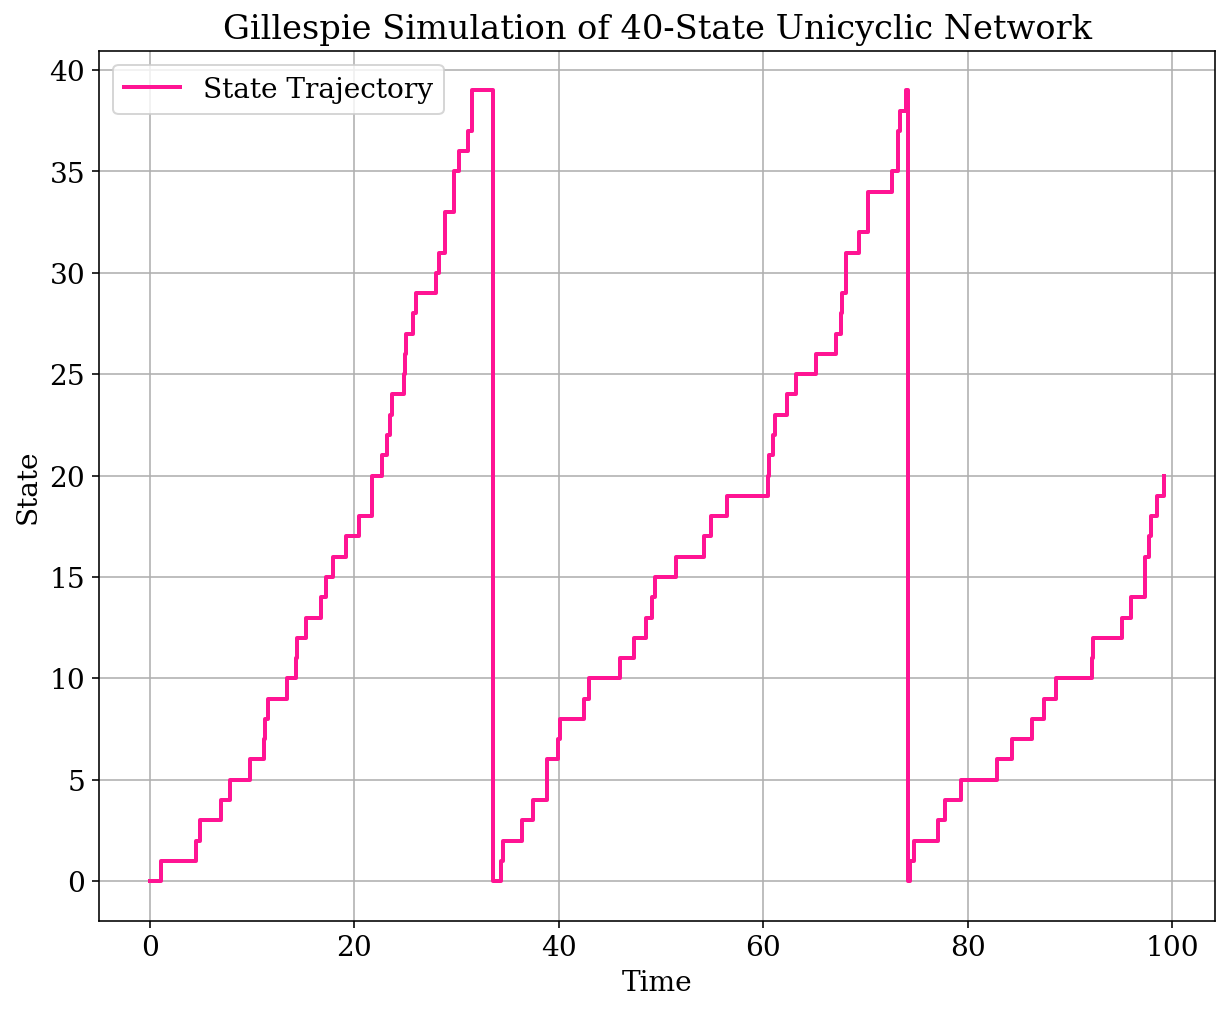

In [23]:
plot_trajectory(times, states)

In [24]:
aff = np.linspace(100,1000,100)
coherences = np.zeros(len(aff))

for i in tqdm(range(len(aff))):
    N = 40
    k_m = 1.0
    A = aff[i]
    k_p = k_m*np.exp(A/N)
    edge_labels_forward = np.array([])
    edge_labels_backward = np.array([])

    for j in range(num_nodes-1):
        u = cycle_list[0][j]
        v = cycle_list[0][j+1]

        G[u][v]['weight'] = k_p
        edge_labels_forward = np.append(edge_labels_forward, k_p)

        G[v][u]['weight'] = k_m
        edge_labels_backward = np.append(edge_labels_backward, k_m)

    G[cycle_list[0][-1]][cycle_list[0][0]]['weight'] = k_p
    edge_labels_forward = np.append(edge_labels_forward, k_p)
    G[cycle_list[0][0]][cycle_list[0][-1]]['weight'] = k_m
    edge_labels_backward = np.append(edge_labels_backward, k_m)
    label_dict = {e: G[e[0]][e[1]]['weight'] for e in G.edges}
    label_list = np.fromiter(label_dict.values(), dtype=float)
    W = Laplacian_all(edge_list,label_list,node_list)
    coherence, x_i, x_r = oscillation_coherence(W)
    coherences[i] = coherence

100%|████████████████████████████████████████| 100/100 [00:00<00:00, 409.45it/s]


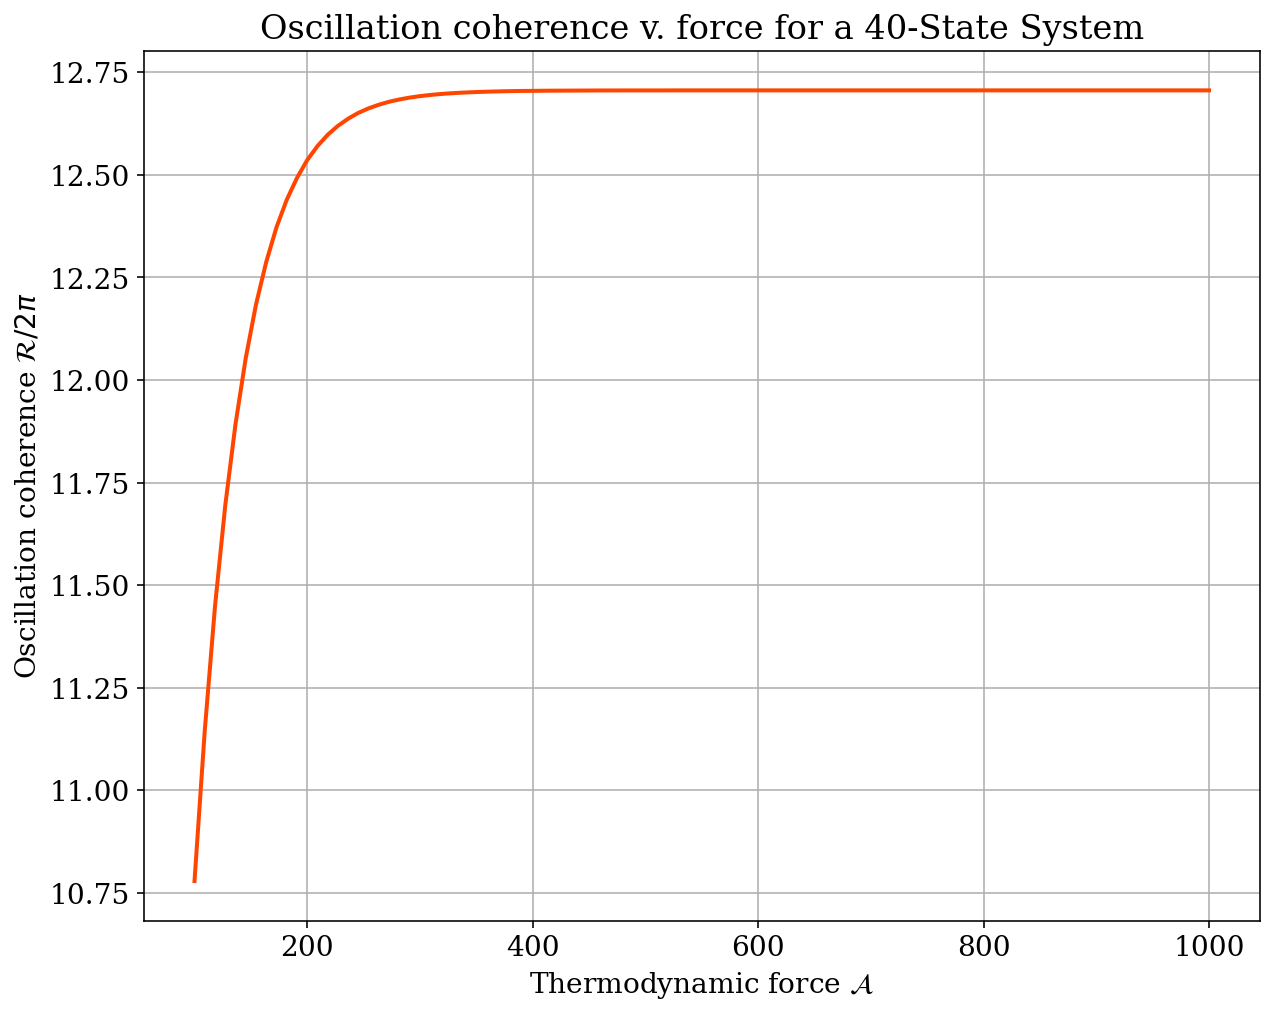

In [25]:
num_states = str(N)

fig, ax = plt.subplots(figsize = (10, 8))
plt.plot(aff, coherences, color = "orangered", linewidth=2)
plt.xlabel(r'Thermodynamic force $\mathcal{A}$')
plt.ylabel(r'Oscillation coherence $\mathcal{R}/2 \pi$')
plt.title('Oscillation coherence v. force for a '+ num_states +'-State System')
plt.grid()
plt.show()

Let us construct a Markov model with state given by $\alpha = \{i, ATP, ADP\}$ where $i = \{1, \dots, 40\}$. Our goal is to now construct a model where we can obtain oscillation coherence as ATP and ADP ae varying dynamically. 

A transition in our model between $\eta = \{2, n_{ATP}, n_{ADP}\}$ and $\eta' = \{3, n_{ATP} - 1, n_{ADP} + 1\}$ is given by,

$$ w_{\eta \to \eta'} = \begin{cases} i = 2 \to 3 \\ ATP = n_{ATP} \to n_{ATP} - 1 \\ ADP = n_{ADP} \to n_{ADP} + 1 \, , \end{cases} $$

$$ w_{\eta' \to \eta} = \begin{cases} i = 3 \to 2 \\ ATP = n_{ATP} - 1 \to n_{ATP} \\ ADP = n_{ADP} + 1 \to n_{ADP} \, . \end{cases} $$

Let $w_{\eta \to \eta'} = k_f n_{ATP}$ and $w_{\eta' \to \eta} = k_r (n_{ADP} +1)$.  From these transition rates, we can impose local detailed balance by setting the force between these two states to equilibrium, 

$$\ln{\left ( \dfrac{w_{\eta \to \eta'}}{w_{\eta' \to \eta}}\right ) } = \dfrac{k_f n_{ATP}}{k_r n_{ADP}} = \dfrac{p^{eq}_{\eta}}{p^{eq}_{\eta'}}\, ,$$

where

$$p^{eq}_{\eta} = \exp{-\beta \left ( E_2 - E_{ATP} n_{ATP} - E_{ADP} n_{ADP} - E_{P_i} n_{P_i}  \right )}\, ,$$

and 

$$p^{eq}_{\eta'} = \exp{-\beta \left ( E_3 - E_{ATP} (n_{ATP}-1) - E_{ADP} (n_{ADP}+1) - E_{P_i} (n_{P_i} +1) \right )}\, .$$

The log of the ratio allows us to cancel many terms,

$$ \ln{\left ( \dfrac{\exp{-\beta \left ( E_2 - E_{ATP} n_{ATP} - E_{ADP} n_{ADP} - E_{P_i} n_{P_i}  \right )}}{\exp{-\beta \left ( E_3 - E_{ATP} (n_{ATP}-1) - E_{ADP} (n_{ADP}+1) - E_{P_i} (n_{P_i} +1) \right )}}\right )} = \beta(\Delta E_{2,3} - E_{ATP} - E_{ADP} - E_{P_i} ) = \Delta E_{2,3} - \Delta E_{ATP,ADP+P_i} \, .$$

This gives us, finally, that,

$$\ln{\left ( \dfrac{k_f n_{ATP}}{k_r n_{ADP}+1} \right )} =\Delta E_{2,3} - \Delta E_{ATP,ADP+P_i} \, , $$

and thus, because $\dfrac{n_{ATP}}{n_{ADP}+1} =\Delta E_{ATP,ADP+P_i}$,

$$\dfrac{k_f}{k_r} = \Delta E_{2,3} \, .$$

Here, we impose local detailed balance between each pair of states in our Markovian system.

In [26]:
import numpy as np
import random

def initialize_transition_rates(N, k_m, A):
    """
    Initialize transition rates for a unicyclic network with N states.
    Optimized to store only necessary transitions.
    """
    transition_rates = {}
    exp_A_N = np.exp(A / N)
    
    for i in range(1, N + 1):
        next_i = 1 if i == N else i + 1
        prev_i = N if i == 1 else i - 1
        
        for n_ATP in range(1, 101):
            for n_ADP in range(1, 1001):
                if n_ATP > 0:
                    transition_rates[(i, n_ATP, n_ADP, next_i, n_ATP - 1, n_ADP + 1)] = k_m * exp_A_N
                if n_ADP > 0:
                    transition_rates[(next_i, n_ATP - 1, n_ADP + 1, i, n_ATP, n_ADP)] = k_m
    
    return transition_rates

def gillespie_3d(initial_state, max_time, transition_rates):
    """
    Simulates a 3D Markov jump process using the Gillespie algorithm with optimized lookups.
    """
    state = list(initial_state)
    time = 0
    trajectory = [(time, *state)]
    
    while time < max_time:
        rates = []
        transitions = []
        
        for (i, atp, adp, new_i, new_atp, new_adp), rate in transition_rates.items():
            if (i, atp, adp) == tuple(state) and rate > 0:
                transitions.append((new_i, new_atp, new_adp))
                rates.append(rate)
        
        if not rates:
            break  # No available transitions
        
        total_rate = sum(rates)
        time += np.random.exponential(1 / total_rate)  # Sample next event time
        
        state[:] = random.choices(transitions, weights=rates)[0]  # Directly update state
        trajectory.append((time, *state))
    
    return trajectory

# Parameters
N = 40
k_m = 1.0
A = 10  # Example thermodynamic force

# Initialize transition rates
transition_rates = initialize_transition_rates(N, k_m, A)

# Run a test simulation
initial_state = (2, 50, 500)
trajectory = gillespie_3d(initial_state, max_time=10, transition_rates=transition_rates)

# Print results
for t, i, atp, adp in trajectory[:10]:
    print(f"t={t:.3f}, i={i}, ATP={atp}, ADP={adp}")

t=0.000, i=2, ATP=50, ADP=500
t=0.014, i=1, ATP=51, ADP=499
t=0.132, i=2, ATP=50, ADP=500
t=0.638, i=3, ATP=49, ADP=501
t=0.650, i=2, ATP=50, ADP=500
t=0.718, i=1, ATP=51, ADP=499
t=0.876, i=2, ATP=50, ADP=500
t=1.057, i=3, ATP=49, ADP=501
t=1.978, i=2, ATP=50, ADP=500
t=2.713, i=1, ATP=51, ADP=499


In [27]:
import numpy as np
import random

def initialize_transition_rates(N, k_m):
    """
    Initialize transition rate dictionary (without predefined rates, since rates now depend on ATP/ADP levels dynamically).
    """
    return {}

def compute_entropy_production(n_ATP, n_ADP, n_P):
    """
    Compute entropy production based on ATP, ADP, and P concentrations.
    """
    if n_ATP > 0 and n_ADP > 0 and n_P > 0:
        return np.log(n_ATP / (n_ADP * n_P))
    return -np.inf  # Prevents invalid calculations

def gillespie_3d(initial_state, max_time, N, k_m):
    """
    Simulates a 3D Markov jump process using the Gillespie algorithm with local detailed balance.
    """
    state = list(initial_state)
    time = 0
    trajectory = [(time, *state)]
    
    while time < max_time:
        i, n_ATP, n_ADP = state
        n_P = 1000  # Assume constant phosphate concentration
        
        rates = []
        transitions = []
        
        next_i = 1 if i == N else i + 1
        prev_i = N if i == 1 else i - 1
        
        # Compute entropy production for forward transition
        delta_s = compute_entropy_production(n_ATP, n_ADP, n_P)
        forward_rate = k_m * np.exp(delta_s / N) if n_ATP > 0 else 0
        reverse_rate = k_m if n_ADP > 0 else 0
        
        if forward_rate > 0:
            transitions.append((next_i, n_ATP - 1, n_ADP + 1))
            rates.append(forward_rate)
        
        if reverse_rate > 0:
            transitions.append((prev_i, n_ATP + 1, n_ADP - 1))
            rates.append(reverse_rate)
        
        if not rates:
            break  # No available transitions
        
        total_rate = sum(rates)
        time += np.random.exponential(1 / total_rate)  # Sample next event time
        
        state[:] = random.choices(transitions, weights=rates)[0]  # Directly update state
        trajectory.append((time, *state))
    
    return trajectory

# Parameters
N = 40
k_m = 1.0

# Run a test simulation
initial_state = (2, 50, 500)
trajectory = gillespie_3d(initial_state, max_time=10, N=N, k_m=k_m)

# Print results
for t, i, atp, adp in trajectory[:10]:
    print(f"t={t:.3f}, i={i}, ATP={atp}, ADP={adp}")

t=0.000, i=2, ATP=50, ADP=500
t=0.649, i=1, ATP=51, ADP=499
t=1.451, i=2, ATP=50, ADP=500
t=2.051, i=3, ATP=49, ADP=501
t=2.251, i=2, ATP=50, ADP=500
t=2.329, i=1, ATP=51, ADP=499
t=2.465, i=2, ATP=50, ADP=500
t=2.530, i=1, ATP=51, ADP=499
t=2.871, i=2, ATP=50, ADP=500
t=3.084, i=1, ATP=51, ADP=499


In [28]:
import numpy as np
import random
from scipy.linalg import eig

def initialize_transition_rates(N, k_m):
    """
    Initialize transition rate dictionary (without predefined rates, since rates now depend on ATP/ADP levels dynamically).
    """
    return {}

def compute_entropy_production(n_ATP, n_ADP, n_P):
    """
    Compute entropy production based on ATP, ADP, and P concentrations.
    """
    if n_ATP > 0 and n_ADP > 0 and n_P > 0:
        return np.log(n_ATP / (n_ADP * n_P))
    return -np.inf  # Prevents invalid calculations

def gillespie_3d(initial_state, max_time, N, k_m):
    """
    Simulates a 3D Markov jump process using the Gillespie algorithm with local detailed balance.
    """
    state = list(initial_state)
    time = 0
    trajectory = [(time, *state)]
    
    while time < max_time:
        i, n_ATP, n_ADP = state
        n_P = 1000  # Assume constant phosphate concentration
        
        rates = []
        transitions = []
        
        next_i = 1 if i == N else i + 1
        prev_i = N if i == 1 else i - 1
        
        # Compute entropy production for forward transition
        delta_s = compute_entropy_production(n_ATP, n_ADP, n_P)
        forward_rate = k_m * np.exp(delta_s / N) if n_ATP > 0 else 0
        reverse_rate = k_m if n_ADP > 0 else 0
        
        if forward_rate > 0:
            transitions.append((next_i, n_ATP - 1, n_ADP + 1))
            rates.append(forward_rate)
        
        if reverse_rate > 0:
            transitions.append((prev_i, n_ATP + 1, n_ADP - 1))
            rates.append(reverse_rate)
        
        if not rates:
            break  # No available transitions
        
        total_rate = sum(rates)
        time += np.random.exponential(1 / total_rate)  # Sample next event time
        
        state[:] = random.choices(transitions, weights=rates)[0]  # Directly update state
        trajectory.append((time, *state))
    
    return trajectory

def construct_transition_matrix(N, k_m, n_ATP, n_ADP, n_P):
    """
    Constructs the transition rate matrix Q for the Markov process.
    """
    Q = np.zeros((N, N))
    for i in range(N):
        next_i = (i + 1) % N
        prev_i = (i - 1) % N
        
        delta_s = compute_entropy_production(n_ATP, n_ADP, n_P)
        forward_rate = k_m * np.exp(delta_s / N) if n_ATP > 0 else 0
        reverse_rate = k_m if n_ADP > 0 else 0
        
        Q[i, next_i] = forward_rate
        Q[i, prev_i] = reverse_rate
        Q[i, i] = - (forward_rate + reverse_rate)
    
    return Q

def compute_oscillation_coherence(Q):
    """
    Computes the oscillation coherence X_I / X_R from the transition matrix Q.
    """
    eigenvalues = eig(Q, right=False)
    sorted_eigenvalues = sorted(eigenvalues, key=lambda x: -np.real(x))
    
    # First nontrivial eigenvalue
    lambda_1 = sorted_eigenvalues[1]
    X_R, X_I = np.real(lambda_1), np.imag(lambda_1)
    
    return X_I / X_R if X_R != 0 else np.inf

# Parameters
N = 40
k_m = 1.0

# Run a test simulation
initial_state = (2, 50, 500)
trajectory = gillespie_3d(initial_state, max_time=10, N=N, k_m=k_m)

# Construct transition matrix and compute coherence
Q = construct_transition_matrix(N, k_m, 50, 500, 1000)
coherence = compute_oscillation_coherence(Q)

print(f"Oscillation Coherence: {coherence:.3f}")

Oscillation Coherence: -1.456


Visited states: [0, 1]
Visited states: [0, 1, 0]
Visited states: [0, 1, 0, 1]
Visited states: [0, 1, 0, 1, 2]
Visited states: [0, 1, 0, 1, 2, 1]
Visited states: [0, 1, 0, 1, 2, 1, 2]
Visited states: [0, 1, 0, 1, 2, 1, 2, 1]
Visited states: [0, 1, 0, 1, 2, 1, 2, 1, 0]
Visited states: [0, 1, 0, 1, 2, 1, 2, 1, 0, 39]
Visited states: [0, 1, 0, 1, 2, 1, 2, 1, 0, 39, 38]
Visited states: [0, 1, 0, 1, 2, 1, 2, 1, 0, 39, 38, 37]
Visited states: [0, 1, 0, 1, 2, 1, 2, 1, 0, 39, 38, 37, 38]
Visited states: [0, 1, 0, 1, 2, 1, 2, 1, 0, 39, 38, 37, 38, 37]
Visited states: [0, 1, 0, 1, 2, 1, 2, 1, 0, 39, 38, 37, 38, 37, 38]
Visited states: [0, 1, 0, 1, 2, 1, 2, 1, 0, 39, 38, 37, 38, 37, 38, 37]
Visited states: [0, 1, 0, 1, 2, 1, 2, 1, 0, 39, 38, 37, 38, 37, 38, 37, 38]
Visited states: [0, 1, 0, 1, 2, 1, 2, 1, 0, 39, 38, 37, 38, 37, 38, 37, 38, 37]
Visited states: [0, 1, 0, 1, 2, 1, 2, 1, 0, 39, 38, 37, 38, 37, 38, 37, 38, 37, 36]
Visited states: [0, 1, 0, 1, 2, 1, 2, 1, 0, 39, 38, 37, 38, 37, 38, 37, 

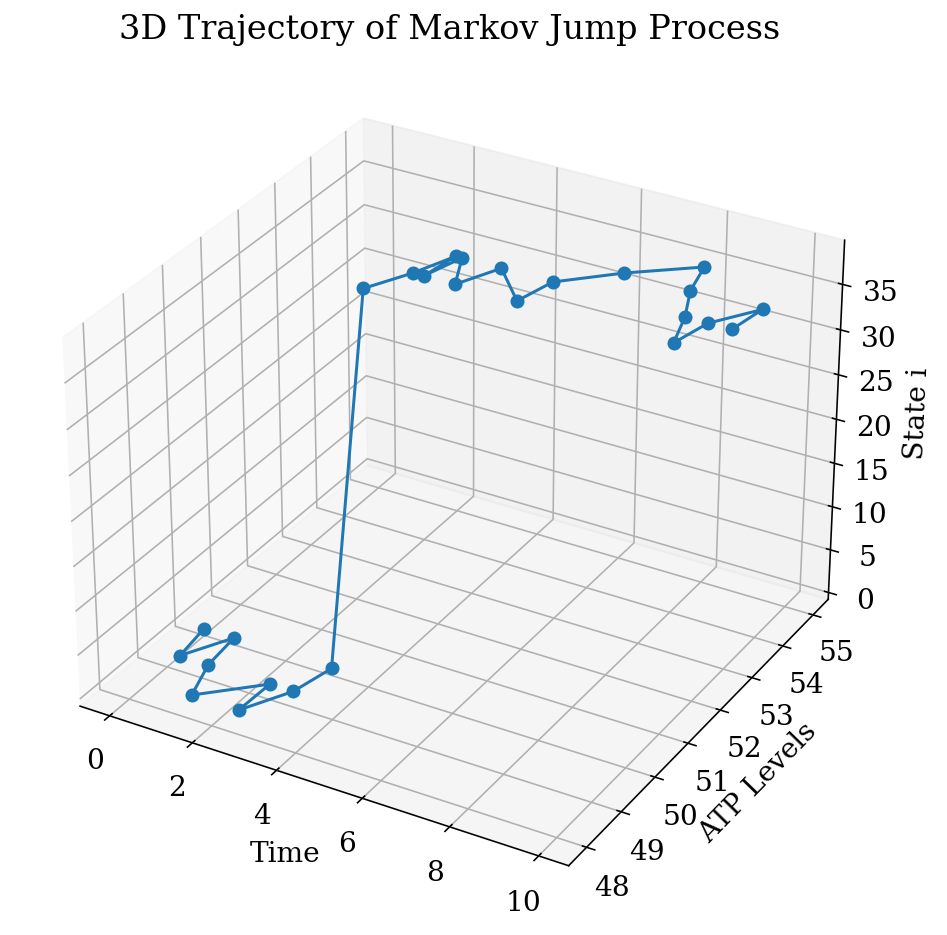

In [39]:
import numpy as np
import random
from scipy.linalg import eig
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def compute_entropy_production(n_ATP, n_ADP, n_P):
    """
    Compute entropy production based on ATP, ADP, and P concentrations.
    """
    if n_ATP > 0 and n_ADP > 0 and n_P > 0:
        return np.log(n_ATP / (n_ADP * n_P))
    return -np.inf  # Prevents invalid calculations

def gillespie_3d_unicyclic(N, F_init, T_max, n_ATP_init, n_ADP_init):
    """
    Simulates a 3D unicyclic Markov jump process using the Gillespie algorithm.
    """
    state = 0 # Start at state 0 in the unicyclic network
    time = 0.0
    F = F_init  # Initial thermodynamic force
    n_ATP, n_ADP = n_ATP_init, n_ADP_init
    n_P = 1000  # Assume constant phosphate concentration
    
    trajectory = [(time, state, n_ATP, n_ADP)]
    states_visited = [state]
    
    while time < T_max:
        # Compute reverse rate dynamically
        k_minus = np.exp(-F / N)
        
        # Compute entropy production
        delta_s = compute_entropy_production(n_ATP, n_ADP, n_P)
        forward_rate = np.exp(delta_s / N) if n_ATP > 0 else 0
        reverse_rate = k_minus if n_ADP > 0 else 0
        
        # Total rate
        total_rate = forward_rate + reverse_rate
        if total_rate == 0:
            break  # No available transitions
        
        # Generate time step from exponential distribution
        tau = -np.log(np.random.rand()) / total_rate
        time += tau
        
        if time > T_max:
            break
        
        # Determine transition
        if np.random.rand() < forward_rate / total_rate:
            state = (state + 1) % N  # Forward move
            n_ATP -= 1
            n_ADP += 1
        else:
            state = (state - 1) % N  # Reverse move
            n_ATP += 1
            n_ADP -= 1
        
        # Update thermodynamic force dynamically
        F *= 1.01  # Modify as needed
        
        trajectory.append((time, state, n_ATP, n_ADP))
        states_visited.append(state)
        
        # Print sequence of visited states
        print("Visited states:", states_visited)
    
    return trajectory

def plot_trajectory_3d(trajectory):
    """
    Plots the trajectory of the 3D Markov jump process in a 3D space.
    """
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    times, states, atp_levels, adp_levels = zip(*trajectory)
    ax.plot(times, atp_levels, states, marker='o', linestyle='-')
    
    ax.set_xlabel("Time")
    ax.set_ylabel("ATP Levels")
    ax.set_zlabel("State i")
    ax.set_title("3D Trajectory of Markov Jump Process")
    plt.show()

# Parameters
N = 40
F_init = 1.0
T_max = 10
n_ATP_init, n_ADP_init = 50, 500

# Run the 3D Gillespie simulation
trajectory = gillespie_3d_unicyclic(N, F_init, T_max, n_ATP_init, n_ADP_init)

# Plot the trajectory
plot_trajectory_3d(trajectory)

In [249]:
# Initialize rates in system back to A = 0 values

k_m = 1.0
A = 0.0
k_p = np.round(k_m*np.exp(A/N),4)

# Assign parameter values to the graph

edge_labels_forward = np.array([])
edge_labels_backward = np.array([])

for i in range(num_nodes-1):
    u = cycle_list[0][i]
    v = cycle_list[0][i+1]
    
    G[u][v]['weight'] = k_p
    edge_labels_forward = np.append(edge_labels_forward, k_p)
    
    G[v][u]['weight'] = k_m
    edge_labels_backward = np.append(edge_labels_backward, k_m)

G[cycle_list[0][-1]][cycle_list[0][0]]['weight'] = k_p
edge_labels_forward = np.append(edge_labels_forward, k_p)
G[cycle_list[0][0]][cycle_list[0][-1]]['weight'] = k_m
edge_labels_backward = np.append(edge_labels_backward, k_m)

label_dict = {e: G[e[0]][e[1]]['weight'] for e in G.edges}
label_list = np.fromiter(label_dict.values(), dtype=float)
W = Laplacian_all(edge_list,label_list,node_list)
affinity = np.round(np.log(np.prod(edge_labels_forward)/np.prod(edge_labels_backward)),4)

affinity
print(G[4][3]['weight'])

1.0


In [250]:
# add state variables for the number of ATP/ADP molecules in the environment
n_ATP = 100
n_ADP = 1

k_23 = G[2][3]['weight']
k_32 = G[3][2]['weight']

all_affinities = np.array([])
force_ratio = np.array([])
all_coherences = np.array([])

times = np.linspace(0.1, 5, 500)

while n_ATP > 0:
    # crudely adding 2 to the current value of the rate
    k_23 = k_23*n_ATP
    k_32 = k_32*n_ADP
    
    # change all data structures
    G[2][3]['weight'] = k_23
    G[3][2]['weight'] = k_32
    # first element in the array is edge 2->3
    edge_labels_forward[0] = k_23
    edge_labels_backward[0] = k_32
    label_dict[2,3] = k_23
    label_dict[3,2] = k_32
    label_list = np.fromiter(label_dict.values(), dtype=float)
    W = Laplacian_all(edge_list,label_list,node_list)
    
    # compute and store affinity
    affinity = np.log(np.prod(edge_labels_forward)/np.prod(edge_labels_backward))
    all_affinities = np.append(all_affinities,affinity)
    
    # compute and store oscillation coherence
    R, x_i, x_r = oscillation_coherence(W)
    all_coherences = np.append(all_coherences,R)
    
    # deplete ATP + add ADP
    n_ATP -= 1
    n_ADP += 1
    force_ratio = np.append(force_ratio, np.log(n_ATP/n_ADP))

/var/folders/ch/f1rl6h5x4fx2wbg2_f5bj5dw0000gn/T/ipykernel_64229/344175447.py:8: RuntimeWarning: invalid value encountered in double_scalars
  R = np.round(x_i/x_r,4)
/var/folders/ch/f1rl6h5x4fx2wbg2_f5bj5dw0000gn/T/ipykernel_64229/935467030.py:41: RuntimeWarning: divide by zero encountered in log
  force_ratio = np.append(force_ratio, np.log(n_ATP/n_ADP))


In [251]:
k_23

9.332621544394418e+157

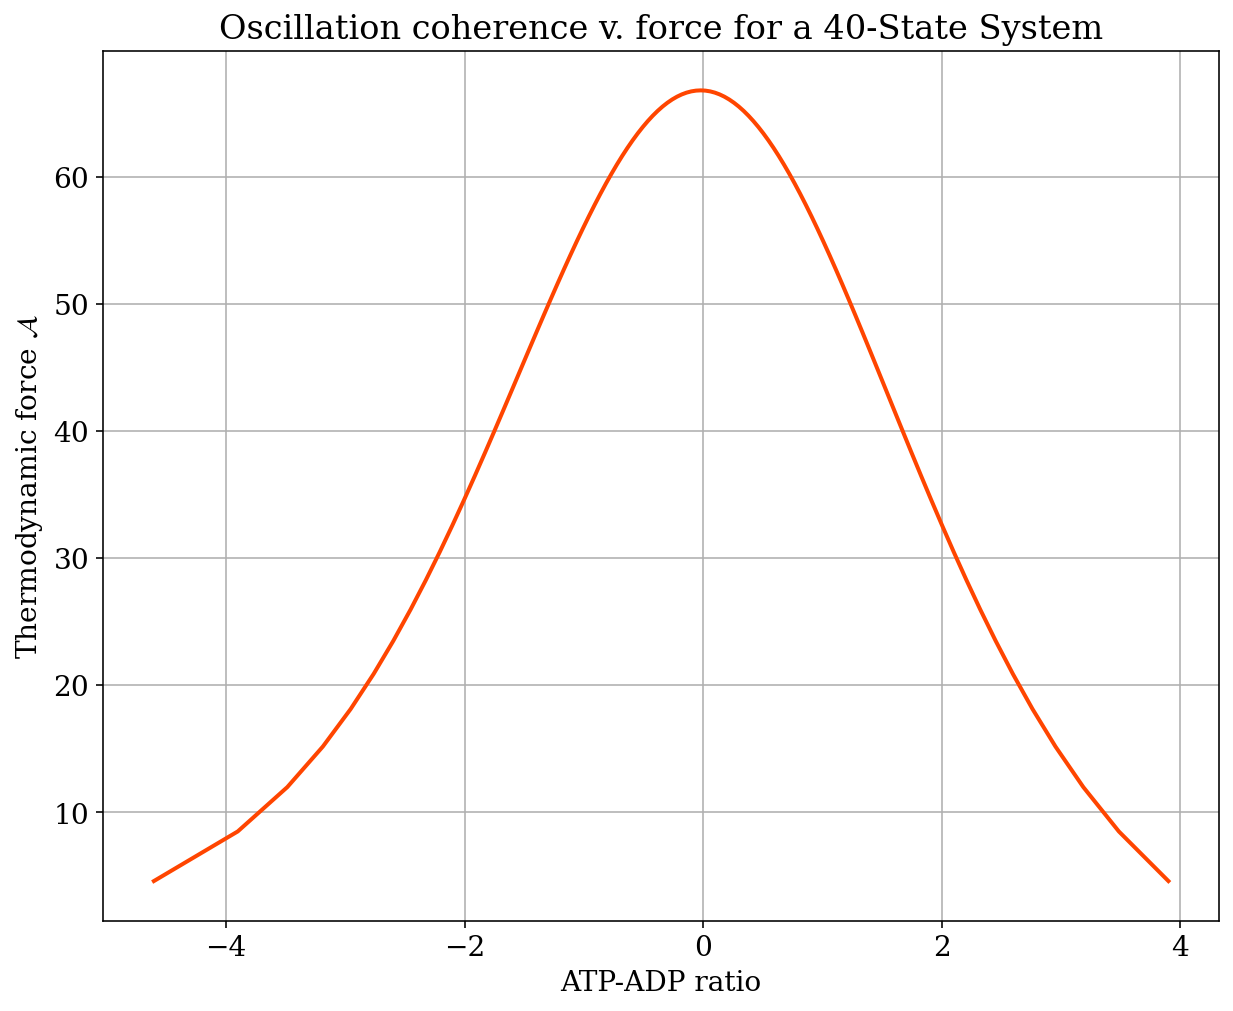

In [255]:
num_states = str(N)

fig, ax = plt.subplots(figsize = (10, 8))
plt.plot(force_ratio, all_affinities, color = "orangered", linewidth=2)
plt.ylabel(r'Thermodynamic force $\mathcal{A}$')
plt.xlabel(r'ATP-ADP ratio')
plt.title('Oscillation coherence v. force for a '+ num_states +'-State System')
plt.grid()
plt.show()

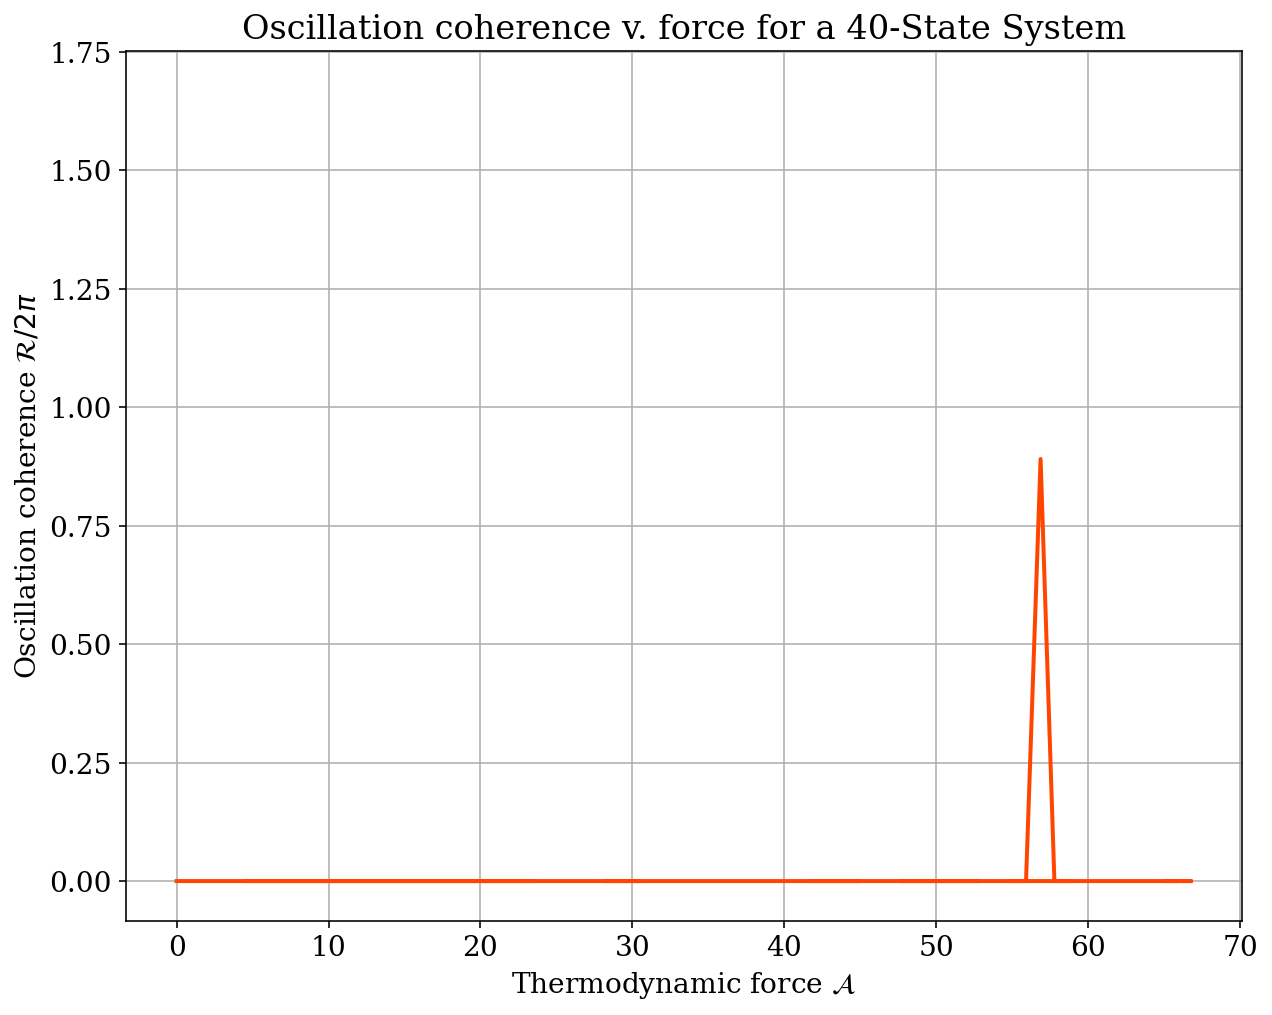

In [254]:
num_states = str(N)

fig, ax = plt.subplots(figsize = (10, 8))
plt.plot(all_affinities, all_coherences, color = "orangered", linewidth=2)
plt.xlabel(r'Thermodynamic force $\mathcal{A}$')
plt.ylabel(r'Oscillation coherence $\mathcal{R}/2 \pi$')
plt.title('Oscillation coherence v. force for a '+ num_states +'-State System')
plt.grid()
plt.show()

In [141]:
ATP = 1000
ADP = 10

#oscillator state
i = np.sort(cycle_list)[0]
# amount of ATP
n_ATP = np.arange(0,ATP)
# amount of ADP
n_ADP = np.arange(0,ADP)